This notebook imports the clustering_results.pkl dataframe and uses it to generates some images from the paper.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import itertools

import sys
sys.path.append('..')
from Clustering_Functions import *

In [18]:
df = pd.read_pickle('../clustering_results.pkl')

In [19]:
print(df.columns)
print(df['method'].unique())

Index(['filename', 'num_cands', 'parties', 'method', 'sil', 'cal', 'dav',
       'centers', 'bloc_size'],
      dtype='object')
['meanBC' 'meanBA' 'meanH' 'medoBC' 'medoBA' 'medoH' 'slate']


There is one row for each election+method pair.

the methods are: 'meanBC' = Lloyd's 2-means with Borda pessimistic, 'medoBA' = PAM 2-medoid with Borda average, etc.

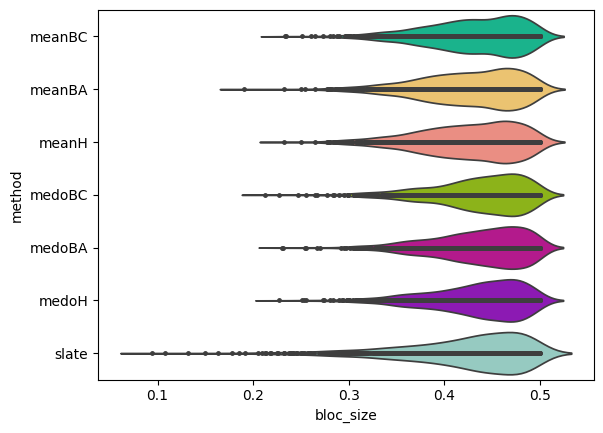

In [8]:
palat = {'meanBC': '#00CD99', 'meanBA': '#FFCA5D', 'meanH': '#FB8072', 'medoBC': '#99CD00', 'medoBA': '#CD0099',
          'medoH': '#9900CD', 'slate': '#8DD3C7'}
fig = sns.violinplot(data = df, x = 'bloc_size', y='method', hue='method', inner='point', 
                     palette = palat)
#fig.figure.savefig('bloc_size.png', dpi=150, bbox_inches='tight')

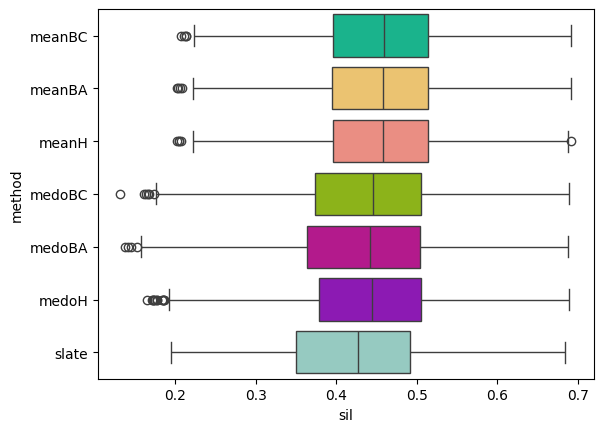

In [10]:
fig = sns.boxplot(data=df, x='sil',y='method', hue = 'method', 
                     palette = palat)
# fig.figure.savefig("sil.png", dpi = 150, bbox_inches = 'tight')

Only the centers are stored, but the full clusterings can be recovered using `Clusters_from_centers` as follows (this takes a few minutes).

In [60]:
D = {'meanBC': ('Borda','pes',True), 'meanBA': ('Borda','avg',True), 'meanH':('HH',None,True),
     'medoBC': ('Borda','pes',False), 'medoBA':('Borda','avg',False), 'medoH': ('HH',None,False), 
     'slate': (None,None,None)}

clustering_list = []

for index in df.index:
    method = df['method'][index]
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    centers = df['centers'][index]
    centers = {i: centers[i] for i in range(len(centers))}

    full_filename = f'../scot-elex/{num_cands}_cands/{filename}'
    _, election, __, ___ = csv_parse(full_filename)
    proxy, borda_style, centers_live_in_proxy_space = D[method]
    if method =='slate':
        C = Slate_cluster(election, slate = centers[0])
    else:
        order = 2 if centers_live_in_proxy_space else 1 # only use 2 for Lloyd.
        _,C = Clusters_from_centers(election, centers, proxy, borda_style, order, centers_live_in_proxy_space)
    clustering_list.append(C)
df['clustering'] = clustering_list

Measure the average over the elections of the closeness of each pair of methods and create an MDS plot of the result

In [61]:
method_list = ["meanBC", "meanBA", "meanH", "medoBC", "medoBA", "medoH", "slate"]
full_filename_list = glob.glob("../scot-elex/**/*.csv")
filename_list = [os.path.basename(x) for x in full_filename_list]

election_to_closssness = dict() # dictionary mapping the election filename to a dictionary mapping method pairs to closeness

for full_filename in full_filename_list:
    num_cands, election, cand_names, location = csv_parse(full_filename)
    filename = os.path.basename(full_filename)
    # print(filename)

    # create dictionary mapping method to clustering
    method_pair_to_clustering = dict()
    for method in method_list:
        method_pair_to_clustering[method] = df[(df['filename'] == filename) & (df['method'] == method)]['clustering'].values[0]

    # create dictionary mapping method pair to closeness
    pair_to_closeness = dict()
    for m1, m2 in itertools.combinations(method_list,2):
        C1 = method_pair_to_clustering[m1]
        C2 = method_pair_to_clustering[m2]
        pair_to_closeness[(m1,m2)] = Clustering_closeness(election,C1,C2) 

    election_to_closssness[filename] = pair_to_closeness

# make dataframe of average closeness of each pair of methods
avg_closeness = pd.DataFrame(columns=method_list, index=method_list)
for m1, m2 in itertools.combinations(method_list, 2):
    avg_closeness.loc[m1,m2] = np.mean([election_to_closssness[filename][(m1,m2)] for filename in filename_list])

# make it into a skey symmetric matrix
for m1, m2 in itertools.product(method_list, method_list):
    if m1 == m2:
        avg_closeness.loc[m1,m2] = 0
    elif pd.isna(avg_closeness.loc[m1,m2]):
        avg_closeness.loc[m1,m2] = avg_closeness.loc[m2,m1]

avg_closeness

,meanBC,meanBA,meanH,medoBC,medoBA,medoH,slate
meanBC,0,0.015595,0.017808,0.071109,0.085867,0.069813,0.120705
meanBA,0.015595,0,0.014123,0.07223,0.083655,0.069904,0.123087
meanH,0.017808,0.014123,0,0.069477,0.082135,0.067336,0.119939
medoBC,0.071109,0.07223,0.069477,0,0.067121,0.0444,0.156096
medoBA,0.085867,0.083655,0.082135,0.067121,0,0.078688,0.177314
medoH,0.069813,0.069904,0.067336,0.0444,0.078688,0,0.155271
slate,0.120705,0.123087,0.119939,0.156096,0.177314,0.155271,0


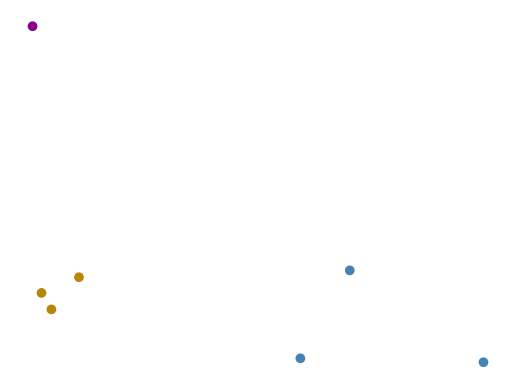

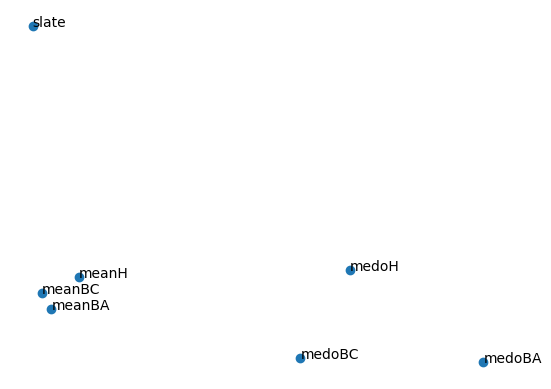

In [62]:
# Create MDS plot of the distances between the methods
projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(avg_closeness)
X = np.array([p[0] for p in projections])
Y = np.array([p[1] for p in projections])

fig, ax = plt.subplots()
ax.scatter(X,Y, c = ['darkgoldenrod','darkgoldenrod','darkgoldenrod','steelblue','steelblue','steelblue','darkmagenta'])
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_unlabled", dpi = 600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(X,Y)
for count in range(len(method_list)):
    ax.annotate(method_list[count], xy=(X[count], Y[count]))
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_labeled", dpi = 600)
plt.show()